In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [3]:
# Connect to database sqlite where is stored the information regarding the Dribbble dataset.
conn = sqlite3.connect("dribbble_temporary.db", detect_types = sqlite3.PARSE_DECLTYPES)
c = conn.cursor()

In [4]:
# Define function to plot a scatter plot and the bisector. 
def scatter_matplotlib(df, x, y):
    with plt.style.context("default"):
        fig, axs = plt.subplots(figsize = (5, 5))
        # Scatter.
        df.plot.scatter(x = x, y = y, s = 8, color = "red", ax = axs)
        # Bisector.
        corners = [df.min()[[x, y]].min(), df.max()[[x, y]].max()]
        axs.plot(corners, corners, color = "black", linestyle = "--", alpha = 0.5)

# Dribbble database (data cleaning)

This notebook deals with fixing some inconsistencies in the Dribbble database. In particular, we notice how  the features *_count* (see tables *users* and *shots*) not reflect the corresponding real values that can be constructed by analyzing the available Dribbble graph. 

For example, a generic user 'X' could have 55 *followers_count* in the *users* table, but counting its followers into the *followers* table we could get 23 followers. This type of inconsistecy is also present for the other features *_count*.

Let's find and fix them.

# Users -- Followers

We want to verify the similarities between the *users* and *followers* table doing a cross-check regarding the **followers_count** and **following_count**.

In [5]:
# Read 'users' table.
users = pd.read_sql("SELECT username, followers_count, followings_count FROM users", conn)
users

,username,followers_count,followings_count
0,cmaffuccio,0,8
1,arestov_design,1106,746
2,space307,435,1991
3,Hido,0,75
4,Avagana,0,93
...,...,...,...
770535,hisevaly,250,603
770536,bonehaus,7193,450
770537,jonhanlan,52,123
770538,stephenandrewmurrill,1333,422


In [6]:
len(users.username.unique())

770540

In [7]:
# Read 'followers' table.
followers = pd.read_sql("SELECT destination, source FROM followers", conn)
followers.head()

,destination,source
0,marklamb,cmaffuccio
1,marklamb,arestov_design
2,marklamb,space307
3,marklamb,Hido
4,marklamb,Avagana


## followers_count

In [8]:
# Count the number of unique followers for the available users.
users_count_followers = followers[["destination", "source"]].set_index("destination").groupby(axis = 0, level = 0).nunique().reset_index()
users_count_followers.rename({"source": "followers_count", "destination": "username"}, axis = 1, inplace = True)
users_count_followers = pd.merge(users[["username"]], users_count_followers, on = "username", how = "outer")
users_count_followers.followers_count.fillna(0, inplace = True)
users_count_followers

,username,followers_count
0,cmaffuccio,0.0
1,arestov_design,1105.0
2,space307,475.0
3,Hido,0.0
4,Avagana,0.0
...,...,...
770535,hisevaly,249.0
770536,bonehaus,6999.0
770537,jonhanlan,52.0
770538,stephenandrewmurrill,1323.0


In [9]:
# Save the dataframe into the sql database.
users_count_followers.to_sql("followers:users_count_followers", conn, index = False, dtype = {"username": "TEXT", "followers_count": "INT"})

In [10]:
# Merge the two sources based on username.
common = pd.merge(users, users_count_followers, left_on = "username", right_on = "username", 
                  suffixes = (":USERS", ":FOLLOWERS"))

# Compute the difference between the two sources.
common["difference"] = (common["followers_count:USERS"] - common["followers_count:FOLLOWERS"]).abs()
common

,username,followers_count:USERS,followings_count,followers_count:FOLLOWERS,difference
0,cmaffuccio,0,8,0.0,0.0
1,arestov_design,1106,746,1105.0,1.0
2,space307,435,1991,475.0,40.0
3,Hido,0,75,0.0,0.0
4,Avagana,0,93,0.0,0.0
...,...,...,...,...,...
770535,hisevaly,250,603,249.0,1.0
770536,bonehaus,7193,450,6999.0,194.0
770537,jonhanlan,52,123,52.0,0.0
770538,stephenandrewmurrill,1333,422,1323.0,10.0


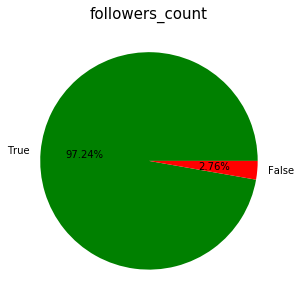

In [11]:
# Percentage of equal (True) and not equal (False).
fig, axs = plt.subplots(figsize = (5, 5))
percentage = (common["difference"] == 0).value_counts(normalize = True)
colours = {True: "green", False: "red"}
axs.pie(percentage, labels = percentage.index, colors = [colours[key] for key in percentage.index], autopct = lambda p:f"{p:.2f}%")
axs.set_title("followers_count", fontsize = 15);

In [12]:
# Isolate the usernames with difference between two sources.
difference = common[(common["difference"] != 0)]

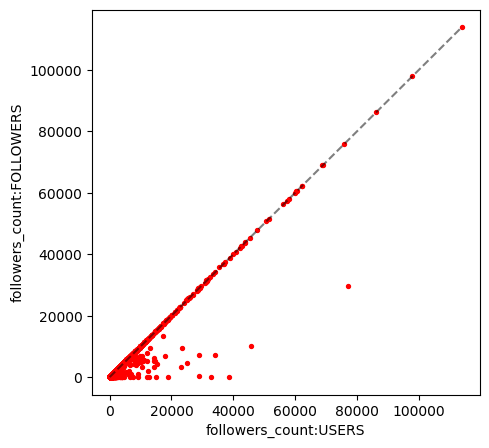

In [13]:
scatter_matplotlib(difference, x = "followers_count:USERS", y = "followers_count:FOLLOWERS")

## followings_count

In [14]:
# Count the number of unique following for the available usernames.
users_count_followings = followers[["destination", "source"]].set_index("source").groupby(axis = 0, level = 0).nunique().reset_index()
users_count_followings.rename({"destination": "followings_count", "source": "username"}, axis = 1, inplace = True)
users_count_followings = pd.merge(users[["username"]], users_count_followings, on = "username", how = "outer")
users_count_followings.followings_count.fillna(0, inplace = True)
users_count_followings

,username,followings_count
0,cmaffuccio,7.0
1,arestov_design,736.0
2,space307,1974.0
3,Hido,74.0
4,Avagana,89.0
...,...,...
770535,hisevaly,577.0
770536,bonehaus,433.0
770537,jonhanlan,121.0
770538,stephenandrewmurrill,398.0


In [15]:
# Save the dataframe into the sql database.
users_count_followings.to_sql("followers:users_count_followings", conn, index = False, dtype = {"username": "TEXT", "followings_count": "INT"})

In [16]:
# Merge the two sources based on username.
common = pd.merge(users, users_count_followings, left_on = "username", right_on = "username", 
                  suffixes = (":USERS", ":FOLLOWERS"))

# Compute the difference between the two sources.
common["difference"] = (common["followings_count:USERS"] - common["followings_count:FOLLOWERS"]).abs()
common

,username,followers_count,followings_count:USERS,followings_count:FOLLOWERS,difference
0,cmaffuccio,0,8,7.0,1.0
1,arestov_design,1106,746,736.0,10.0
2,space307,435,1991,1974.0,17.0
3,Hido,0,75,74.0,1.0
4,Avagana,0,93,89.0,4.0
...,...,...,...,...,...
770535,hisevaly,250,603,577.0,26.0
770536,bonehaus,7193,450,433.0,17.0
770537,jonhanlan,52,123,121.0,2.0
770538,stephenandrewmurrill,1333,422,398.0,24.0


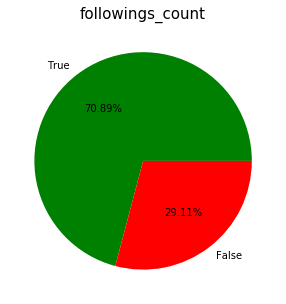

In [17]:
# Percentage of equal (True) and not equal (False).
fig, axs = plt.subplots(figsize = (5, 5))
percentage = (common["difference"] == 0).value_counts(normalize = True)
colours = {True: "green", False: "red"}
axs.pie(percentage, labels = percentage.index, colors = [colours[key] for key in percentage.index], autopct = lambda p:f"{p:.2f}%")
axs.set_title("followings_count", fontsize = 15);

In [18]:
# Isolate the usernames with difference between two sources.
difference = common[(common["difference"] != 0)]

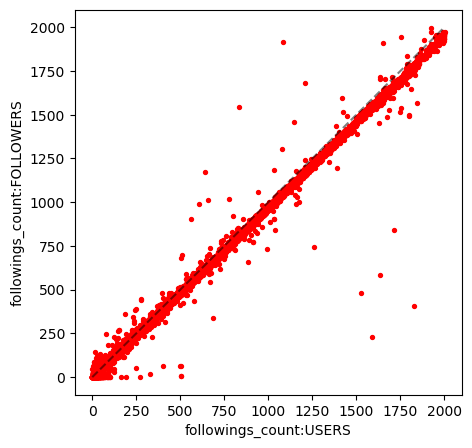

In [19]:
scatter_matplotlib(difference, x = "followings_count:USERS", y = "followings_count:FOLLOWERS")

# Users -- Teams

We want to verify the similarities between the *users* and *teams* tables doing a cross-check regarding the **teams_count** and **members_count**.

In [20]:
# Read 'users' table.
users = pd.read_sql("SELECT username, teams_count, members_count, type FROM users", conn)
users.head()

,username,teams_count,members_count,type
0,cmaffuccio,0.0,NaN,User
1,arestov_design,0.0,NaN,Player
2,space307,NaN,8.0,Team
3,Hido,0.0,NaN,User
4,Avagana,0.0,NaN,User


In [21]:
# Number of unique teams according to 'users' table.
teams_in_users = users[users.type == "Team"]["username"].unique()

In [22]:
len(teams_in_users)

3914

In [23]:
# Read 'teams' table.
teams = pd.read_sql("SELECT * FROM teams", conn)
teams.head()

,member_username,team_username,n_of_shots,first_shot,last_shot,id_member_username,id_team_username
0,-jk-,brandsprogram,9,2015-11-23 15:22:33,2016-10-03 09:15:54,506623,938258
1,09ui,hi09ui,2,2015-08-06 02:37:23,2016-06-18 08:16:03,900091,759443
2,100shapes,100shapes,4,2015-02-12 11:00:06,2015-05-15 14:42:21,760435,760435
3,10Clouds,10Clouds,7,2015-05-12 10:25:27,2017-11-10 10:31:29,845019,845019
4,10up,10up,1,2017-12-12 19:34:43,2017-12-12 20:35:43,5473,5473


In [24]:
set(teams.team_username.unique()).issubset(set(teams_in_users))

True

## teams_count

In [25]:
# Count the number of teams where users (no teams) have worked.
users_count_teams = teams[~teams.member_username.isin(teams_in_users)].reset_index(drop = True)[["member_username", "team_username"]]
users_count_teams = users_count_teams.set_index("member_username").groupby(axis = 0, level = 0).nunique().reset_index()
users_count_teams.rename({"team_username": "teams_count"}, axis = 1, inplace = True)
users_count_teams

,member_username,teams_count
0,-jk-,1
1,09ui,1
2,123OMGOMG,1
3,14eleven,1
4,1dollarpsd,1
...,...,...
10158,zvandehey,1
10159,zwartekoffie,1
10160,zxdenny,1
10161,zzrrome,1


In [26]:
# Keep users that not are teams and not have any information into 'users_count_teams' table.
users_without_team = users[(users.type != "Team") & (~users.username.isin(users_count_teams.member_username))]["username"]

In [27]:
no_teams = pd.DataFrame(columns = users_count_teams.columns)
no_teams["member_username"] = users_without_team
no_teams["teams_count"] = 0

In [28]:
users_count_teams = pd.concat([users_count_teams, no_teams], ignore_index = False).reset_index(drop = True)
users_count_teams

,member_username,teams_count
0,-jk-,1
1,09ui,1
2,123OMGOMG,1
3,14eleven,1
4,1dollarpsd,1
...,...,...
766621,julytkachenko,0
766622,SebKayDesign,0
766623,hisevaly,0
766624,jonhanlan,0


In [29]:
# Verify the total amount of users.
len(users_count_teams.member_username) + len(users[users.type == "Team"])

770540

In [30]:
# Save the dataframe into the sql database.
users_count_teams.to_sql("teams:users_count_teams", conn, index = False, dtype = {"member_username": "TEXT", "teams_count": "INT"})

In [31]:
# Select only users (no teams) from 'users' table.
users_count = users[users.username.isin(users_count_teams.member_username.unique())][["username", "teams_count"]]

# Merge the two sources based on username.
common = pd.merge(users_count, users_count_teams, left_on = "username", right_on = "member_username", 
                  suffixes = (":USERS", ":TEAMS"))

# Compute the difference between the two sources.
common["difference"] = (common["teams_count:USERS"] - common["teams_count:TEAMS"]).abs()
common

,username,teams_count:USERS,member_username,teams_count:TEAMS,difference
0,cmaffuccio,0.0,cmaffuccio,0,0.0
1,arestov_design,0.0,arestov_design,0,0.0
2,Hido,0.0,Hido,0,0.0
3,Avagana,0.0,Avagana,0,0.0
4,prem_kumar,0.0,prem_kumar,0,0.0
...,...,...,...,...,...
766621,hisevaly,0.0,hisevaly,0,0.0
766622,bonehaus,0.0,bonehaus,1,1.0
766623,jonhanlan,0.0,jonhanlan,0,0.0
766624,stephenandrewmurrill,1.0,stephenandrewmurrill,1,0.0


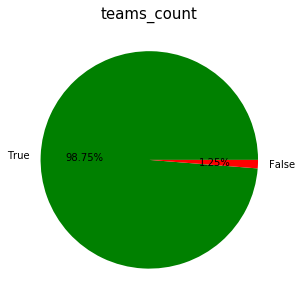

In [32]:
# Percentage of equal (True) and not equal (False).
fig, axs = plt.subplots(figsize = (5, 5))
percentage = (common["difference"] == 0).value_counts(normalize = True)
colours = {True: "green", False: "red"}
axs.pie(percentage, labels = percentage.index, colors = [colours[key] for key in percentage.index], autopct = lambda p:f"{p:.2f}%")
axs.set_title("teams_count", fontsize = 15);

In [33]:
# Isolate the usernames with difference between two sources.
difference = common[(common["difference"] != 0)]

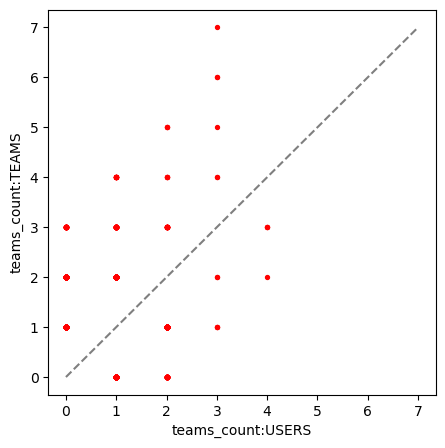

In [34]:
scatter_matplotlib(difference, x = "teams_count:USERS", y = "teams_count:TEAMS")

## members_count

In [35]:
# Count the ascertain number of members (no team) for each team.
teams_count_members = teams[~teams.member_username.isin(teams_in_users)].reset_index(drop = True)[["member_username", "team_username"]]
teams_count_members = teams_count_members.set_index("team_username").groupby(axis = 0, level = 0).nunique().reset_index()
teams_count_members.rename({"member_username": "members_count"}, axis = 1, inplace = True)
teams_count_members

,team_username,members_count
0,1099group,3
1,10Clouds,13
2,10up,4
3,1337s,2
4,15Five,1
...,...,...
3209,zooom,2
3210,zunostudios,2
3211,zuora,1
3212,zurb,2


In [36]:
# Keep users that are teams and not have any information into 'users_count_teams' table.
team_without_members = users[(users.type == "Team") & (~users.username.isin(teams_count_members.team_username))]["username"]

In [37]:
no_members = pd.DataFrame(columns = teams_count_members.columns)
no_members["team_username"] = team_without_members
no_members["members_count"] = 0

In [38]:
teams_count_members = pd.concat([teams_count_members, no_members], ignore_index = False).reset_index(drop = True)
teams_count_members

,team_username,members_count
0,1099group,3
1,10Clouds,13
2,10up,4
3,1337s,2
4,15Five,1
...,...,...
3909,xyz011,0
3910,hometeam,0
3911,aminohealth,0
3912,lilosocial,0


In [39]:
# Save the dataframe into the sql database.
teams_count_members.to_sql("teams:teams_count_members", conn, index = False, dtype = {"team_username": "TEXT", "members_count": "INT"})

In [40]:
# Select only teams from 'users' table.
users_count = users[(users.type == "Team")][["username", "members_count"]]

# Merge the two sources based on username.
common = pd.merge(users_count, teams_count_members, left_on = "username", right_on = "team_username", 
                  suffixes = (":USERS", ":TEAMS"))

# Compute the difference between the two sources.
common["difference"] = (common["members_count:USERS"] - common["members_count:TEAMS"]).abs()
common

,username,members_count:USERS,team_username,members_count:TEAMS,difference
0,space307,8.0,space307,8,0.0
1,citrusbyte,18.0,citrusbyte,13,5.0
2,designers_how,2.0,designers_how,2,0.0
3,blackflagcreative,2.0,blackflagcreative,2,0.0
4,alem,2.0,alem,1,1.0
...,...,...,...,...,...
3909,bem_design,3.0,bem_design,0,3.0
3910,IrisDvir,1.0,IrisDvir,1,0.0
3911,MindbodyDesign,3.0,MindbodyDesign,1,2.0
3912,studitempstech,2.0,studitempstech,2,0.0


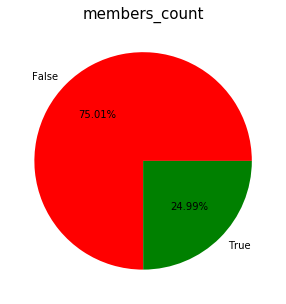

In [41]:
# Percentage of equal (True) and not equal (False).
fig, axs = plt.subplots(figsize = (5, 5))
percentage = (common["difference"] == 0).value_counts(normalize = True)
colours = {True: "green", False: "red"}
axs.pie(percentage, labels = percentage.index, colors = [colours[key] for key in percentage.index], autopct = lambda p:f"{p:.2f}%")
axs.set_title("members_count", fontsize = 15);

In [42]:
# Isolate the usernames with difference between two sources.
difference = common[(common["difference"] != 0)]

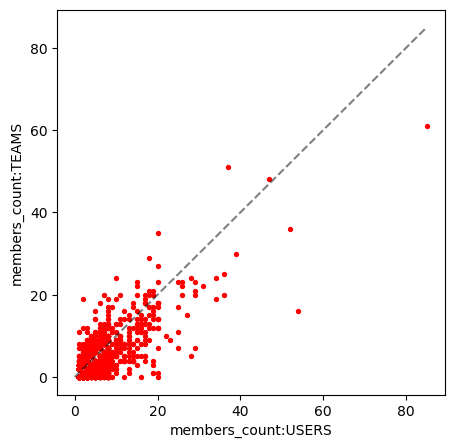

In [43]:
scatter_matplotlib(difference, x = "members_count:USERS", y = "members_count:TEAMS")

# Users -- Shots, Comments

We want to verify the similarities between the *users*, *shots* and *comments* tables doing a cross-check regarding the **comments_received_count**, **shots_count** and **comments_count** (extra).

In [44]:
# Read 'users' table.
users = pd.read_sql("SELECT username, comments_received_count, shots_count FROM users", conn)
users.head()

,username,comments_received_count,shots_count
0,cmaffuccio,0,0
1,arestov_design,101,65
2,space307,0,39
3,Hido,0,0
4,Avagana,0,0


In [45]:
# Read 'shots' table.
shots = pd.read_sql("SELECT author_shot, shot_id FROM shots", conn)
shots.head()

,author_shot,shot_id
0,max_palyvoda,3549658
1,max_palyvoda,3254544
2,max_palyvoda,3153930
3,miketanael,3732805
4,citrusbyte,2686725


In [46]:
# Read 'comments' table.
comments = pd.read_sql("SELECT shot_id, comment_id, author_comment FROM comments", conn)
comments.head()

,shot_id,comment_id,author_comment
0,295643,738715,liammckay
1,1696672,3994002,chadfullerton
2,1696672,3994160,sammer
3,1691148,3889476,jalenconner
4,1691148,3891158,arnaudschlupp


## comments_received_count

In [47]:
union = pd.merge(shots, comments, on = "shot_id", suffixes = ("_shot", "_comment"))
union.head()

,author_shot,shot_id,comment_id,author_comment
0,max_palyvoda,3549658,6257065,NestStrix
1,max_palyvoda,3549658,6257073,max_palyvoda
2,max_palyvoda,3549658,6257651,denyskurnosov
3,max_palyvoda,3549658,6257658,max_palyvoda
4,max_palyvoda,3549658,6641778,mirokirov


In [48]:
# Count the number of comments received (unique) by the available users.
comments_received_count_users = union[["author_shot", "comment_id"]].set_index("author_shot").groupby(axis = 0, level = 0).nunique().reset_index()
comments_received_count_users.rename({"comment_id": "comments_received_count", "author_shot": "username"}, axis = 1, inplace = True)
comments_received_count_users = pd.merge(users[["username"]], comments_received_count_users, on = "username", how = "outer")
comments_received_count_users.comments_received_count.fillna(0, inplace = True)
comments_received_count_users

,username,comments_received_count
0,cmaffuccio,0.0
1,arestov_design,117.0
2,space307,0.0
3,Hido,0.0
4,Avagana,0.0
...,...,...
770535,hisevaly,0.0
770536,bonehaus,1859.0
770537,jonhanlan,24.0
770538,stephenandrewmurrill,183.0


In [49]:
# Save the dataframe into the sql database.
comments_received_count_users.to_sql("shots:comments_received_count_users", conn, index = False, dtype = {"username": "TEXT", "comments_received_count": "INT"})

In [50]:
# Merge the two sources based on username.
common = pd.merge(users, comments_received_count_users, left_on = "username", right_on = "username", 
                  suffixes = (":USERS", ":SHOTS-COMMENTS"))

# Compute the difference between the two sources.
common["difference"] = (common["comments_received_count:USERS"] - common["comments_received_count:SHOTS-COMMENTS"]).abs()
common

,username,comments_received_count:USERS,shots_count,comments_received_count:SHOTS-COMMENTS,difference
0,cmaffuccio,0,0,0.0,0.0
1,arestov_design,101,65,117.0,16.0
2,space307,0,39,0.0,0.0
3,Hido,0,0,0.0,0.0
4,Avagana,0,0,0.0,0.0
...,...,...,...,...,...
770535,hisevaly,-43,1,0.0,43.0
770536,bonehaus,1763,379,1859.0,96.0
770537,jonhanlan,24,72,24.0,0.0
770538,stephenandrewmurrill,151,104,183.0,32.0


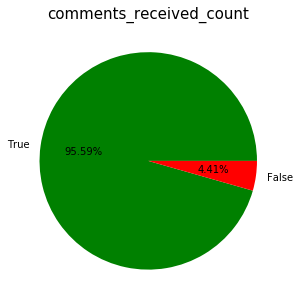

In [51]:
# Percentage of equal (True) and not equal (False).
fig, axs = plt.subplots(figsize = (5, 5))
percentage = (common["difference"] == 0).value_counts(normalize = True)
colours = {True: "green", False: "red"}
axs.pie(percentage, labels = percentage.index, colors = [colours[key] for key in percentage.index], autopct = lambda p:f"{p:.2f}%")
axs.set_title("comments_received_count", fontsize = 15);

In [52]:
# Isolate the usernames with difference between two sources.
difference = common[(common["difference"] != 0)]

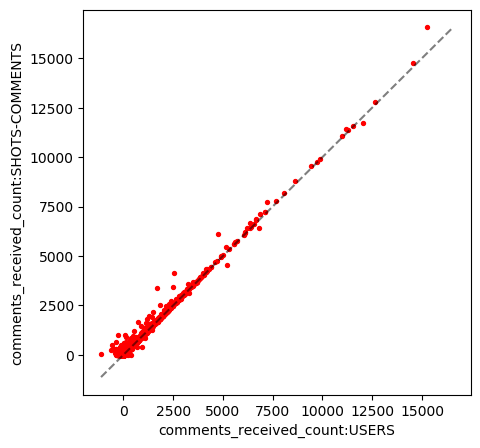

In [53]:
scatter_matplotlib(difference, x = "comments_received_count:USERS", y = "comments_received_count:SHOTS-COMMENTS")

## shots_count

In [54]:
# Count the number of shots (unique) posted by the available users.
users_count_shots = shots[["author_shot", "shot_id"]].set_index("author_shot").groupby(axis = 0, level = 0).nunique().reset_index()
users_count_shots.rename({"shot_id": "shots_count", "author_shot": "username"}, axis = 1, inplace = True)
users_count_shots = pd.merge(users[["username"]], users_count_shots, on = "username", how = "outer")
users_count_shots.shots_count.fillna(0, inplace = True)
users_count_shots

,username,shots_count
0,cmaffuccio,0.0
1,arestov_design,65.0
2,space307,0.0
3,Hido,0.0
4,Avagana,0.0
...,...,...
770535,hisevaly,30.0
770536,bonehaus,376.0
770537,jonhanlan,69.0
770538,stephenandrewmurrill,103.0


In [55]:
# Save the dataframe into the sql database.
users_count_shots.to_sql("shots:users_count_shots", conn, index = False, dtype = {"username": "TEXT", "shots_count": "INT"})

In [56]:
# Merge the two sources based on username.
common = pd.merge(users, users_count_shots, left_on = "username", right_on = "username", 
                  suffixes = (":USERS", ":SHOTS"))

# Compute the difference between the two sources.
common["difference"] = (common["shots_count:USERS"] - common["shots_count:SHOTS"]).abs()
common

,username,comments_received_count,shots_count:USERS,shots_count:SHOTS,difference
0,cmaffuccio,0,0,0.0,0.0
1,arestov_design,101,65,65.0,0.0
2,space307,0,39,0.0,39.0
3,Hido,0,0,0.0,0.0
4,Avagana,0,0,0.0,0.0
...,...,...,...,...,...
770535,hisevaly,-43,1,30.0,29.0
770536,bonehaus,1763,379,376.0,3.0
770537,jonhanlan,24,72,69.0,3.0
770538,stephenandrewmurrill,151,104,103.0,1.0


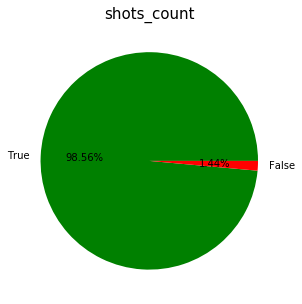

In [57]:
# Percentage of equal (True) and not equal (False).
fig, axs = plt.subplots(figsize = (5, 5))
percentage = (common["difference"] == 0).value_counts(normalize = True)
colours = {True: "green", False: "red"}
axs.pie(percentage, labels = percentage.index, colors = [colours[key] for key in percentage.index], autopct = lambda p:f"{p:.2f}%")
axs.set_title("shots_count", fontsize = 15);

In [58]:
# Isolate the usernames with difference between two sources.
difference = common[(common["difference"] != 0)]

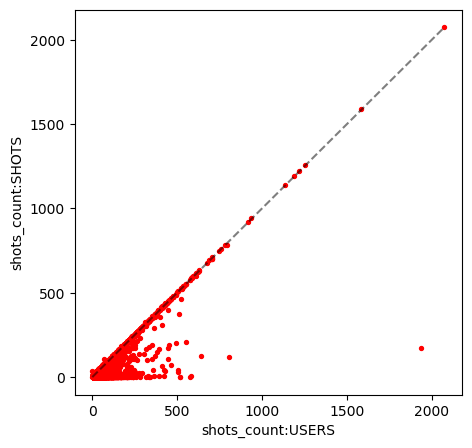

In [59]:
scatter_matplotlib(difference, x = "shots_count:USERS", y = "shots_count:SHOTS")

## comments_count (extra)

In [60]:
# Count the number of comments left by the users.
comments_count_users = comments[["author_comment", "comment_id"]].set_index("author_comment").groupby(axis = 0, level = 0).nunique().reset_index()
comments_count_users.rename({"comment_id": "comments_count", "author_comment": "username"}, axis = 1, inplace = True)
comments_count_users = pd.merge(users[["username"]], comments_count_users, on = "username", how = "outer")
comments_count_users.comments_count.fillna(0, inplace = True)
comments_count_users

,username,comments_count
0,cmaffuccio,0.0
1,arestov_design,111.0
2,space307,3.0
3,Hido,0.0
4,Avagana,0.0
...,...,...
770535,hisevaly,8.0
770536,bonehaus,1322.0
770537,jonhanlan,56.0
770538,stephenandrewmurrill,58.0


In [61]:
# Save the dataframe into the sql database.
comments_count_users.to_sql("comments:comments_count_users", conn, index = False, dtype = {"username": "TEXT", "comments_count": "INT"})

# Users -- Likes

We want to verify the similarities between the *users* and *likes* tables by doing a cross-checking regarding the **likes_count** and **likes_received_count**.

In [62]:
# Read 'users' table.
users = pd.read_sql("SELECT username, likes_received_count, likes_count  FROM users", conn)
users.head()

,username,likes_received_count,likes_count
0,cmaffuccio,0,0
1,arestov_design,4872,5456
2,space307,0,2447
3,Hido,0,82
4,Avagana,0,38


## likes_count

In [63]:
# Count the number of unique likes left by each user.
c.execute("""CREATE TABLE 'likes:users_count_likes' AS SELECT author_like AS username, COUNT(DISTINCT like_id) 
                AS likes_count FROM likes GROUP BY author_like""")
conn.commit()

In [64]:
users_count_likes = pd.read_sql("SELECT * FROM 'likes:users_count_likes'", conn)
users_count_likes

,username,likes_count
0,$$,1
1,$aro,4
2,---,21
3,------,16
4,-----12----34,7
...,...,...
556186,远夏,3
556187,限制级网络,3
556188,麦小麦,1
556189,黑花生,3


In [65]:
# Keep users that never left a like.
users_without_likes = users[~users.username.isin(users_count_likes.username)]["username"]

In [66]:
# Insert the values of 0 likes_count for the users that never left a like.
no_likes = pd.DataFrame(columns = users_count_likes.columns)
no_likes["username"] = users_without_likes
no_likes["likes_count"] = 0

data_to_insert = no_likes.values.tolist()

# Insert data into sql table recursively.
c.executemany("INSERT INTO 'likes:users_count_likes' (username, likes_count) VALUES (?, ?)", data_to_insert)
conn.commit()

In [67]:
users_count_likes = pd.read_sql("SELECT * FROM 'likes:users_count_likes'", conn)
users_count_likes

,username,likes_count
0,$$,1
1,$aro,4
2,---,21
3,------,16
4,-----12----34,7
...,...,...
770535,DandM,0
770536,HEIZITAIYANG,0
770537,ecorreia__,0
770538,WLDIndia,0


In [68]:
# Merge the two sources based on username.
common = pd.merge(users, users_count_likes, left_on = "username", right_on = "username", 
                  suffixes = (":USERS", ":LIKES"))

# Compute the difference between the two sources.
common["difference"] = (common["likes_count:USERS"] - common["likes_count:LIKES"]).abs()
common

,username,likes_received_count,likes_count:USERS,likes_count:LIKES,difference
0,cmaffuccio,0,0,0,0
1,arestov_design,4872,5456,5484,28
2,space307,0,2447,2835,388
3,Hido,0,82,82,0
4,Avagana,0,38,38,0
...,...,...,...,...,...
770535,hisevaly,16,346,348,2
770536,bonehaus,41724,3377,3357,20
770537,jonhanlan,1049,96,94,2
770538,stephenandrewmurrill,6022,3270,3210,60


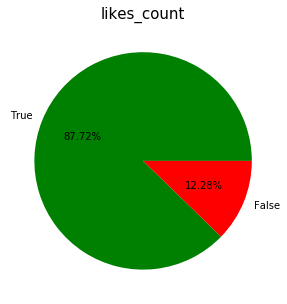

In [69]:
# Percentage of equal (True) and not equal (False).
fig, axs = plt.subplots(figsize = (5, 5))
percentage = (common["difference"] == 0).value_counts(normalize = True)
colours = {True: "green", False: "red"}
axs.pie(percentage, labels = percentage.index, colors = [colours[key] for key in percentage.index], autopct = lambda p:f"{p:.2f}%")
axs.set_title("likes_count", fontsize = 15);

In [70]:
# Isolate the usernames with difference between two sources.
difference = common[(common["difference"] != 0)]

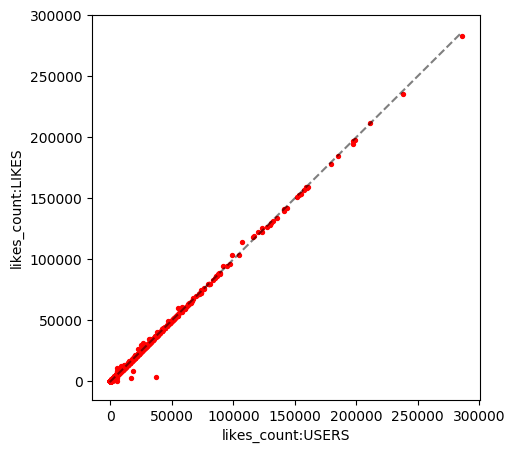

In [71]:
scatter_matplotlib(difference, x = "likes_count:USERS", y = "likes_count:LIKES")

## likes_received_count

In [72]:
# Count the number of unique likes received by each users.
c.execute("""CREATE TABLE 'likes:likes_received_count_users' AS SELECT shots.author_shot AS username, COUNT(DISTINCT likes.like_id) AS likes_received_count
                FROM shots INNER JOIN likes 
                    ON shots.shot_id = likes.shot_id
                GROUP BY shots.author_shot""")
conn.commit()

In [73]:
likes_received_count_users = pd.read_sql("SELECT * FROM 'likes:likes_received_count_users'", conn)
likes_received_count_users

,username,likes_received_count
0,-Alina-,470
1,-Alx-,35
2,-Eco-,71
3,-Geminisama,25
4,-K-,167
...,...,...
107108,zzzerch,19
107109,zzzmeysss,1005
107110,zzznilzzz,1017
107111,zzzxxx,110


In [74]:
# Keep users that never received a like.
users_without_likes = users[~users.username.isin(likes_received_count_users.username)]["username"]

In [75]:
# Insert the values of 0 likes_count for the users that never received a like.
no_likes = pd.DataFrame(columns = likes_received_count_users.columns)
no_likes["username"] = users_without_likes
no_likes["likes_received_count"] = 0

data_to_insert = no_likes.values.tolist()

# Insert data into sql table recursively.
c.executemany("INSERT INTO 'likes:likes_received_count_users' (username, likes_received_count) VALUES (?, ?)", data_to_insert)
conn.commit()

In [76]:
likes_received_count_users = pd.read_sql("SELECT * FROM 'likes:likes_received_count_users'", conn)
likes_received_count_users

,username,likes_received_count
0,-Alina-,470
1,-Alx-,35
2,-Eco-,71
3,-Geminisama,25
4,-K-,167
...,...,...
770535,82donutlife,0
770536,jam_888888,0
770537,kageyama,0
770538,zina,0


In [77]:
# Merge the two sources based on username.
common = pd.merge(users, likes_received_count_users, left_on = "username", right_on = "username", 
                  suffixes = (":USERS", ":LIKES"))

# Compute the difference between the two sources.
common["difference"] = (common["likes_received_count:USERS"] - common["likes_received_count:LIKES"]).abs()
common

,username,likes_received_count:USERS,likes_count,likes_received_count:LIKES,difference
0,cmaffuccio,0,0,0,0
1,arestov_design,4872,5456,4873,1
2,space307,0,2447,0,0
3,Hido,0,82,0,0
4,Avagana,0,38,0,0
...,...,...,...,...,...
770535,hisevaly,16,346,421,405
770536,bonehaus,41724,3377,40996,728
770537,jonhanlan,1049,96,1020,29
770538,stephenandrewmurrill,6022,3270,5903,119


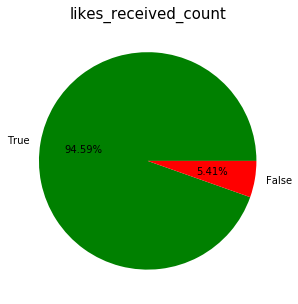

In [78]:
# Percentage of equal (True) and not equal (False).
fig, axs = plt.subplots(figsize = (5, 5))
percentage = (common["difference"] == 0).value_counts(normalize = True)
colours = {True: "green", False: "red"}
axs.pie(percentage, labels = percentage.index, colors = [colours[key] for key in percentage.index], autopct = lambda p:f"{p:.2f}%")
axs.set_title("likes_received_count", fontsize = 15);

In [79]:
# Isolate the usernames with difference between two sources.
difference = common[(common["difference"] != 0)]

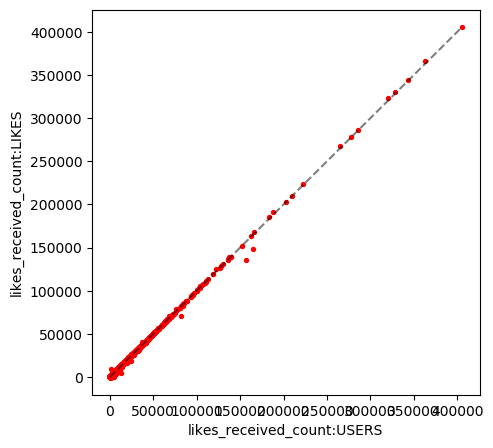

In [80]:
scatter_matplotlib(difference, x = "likes_received_count:USERS", y = "likes_received_count:LIKES")

# Users -- Skills

We want compute an extra information regarding **skills_count**.

In [81]:
skills = pd.read_sql("SELECT * FROM skills", conn)
skills.head()

,username,skill,id_username
0,arestov_design,art direction,695302
1,arestov_design,banking,695302
2,arestov_design,cryptocurrency,695302
3,arestov_design,design systems,695302
4,arestov_design,fintech,695302


## skills_count (extra)

In [82]:
# Count the total number of unique skills for each user.
users_count_skills = skills[["username", "skill"]].set_index("username").groupby(axis = 0, level = 0).nunique().reset_index()
users_count_skills.rename({"skill": "skills_count"}, axis = 1, inplace = True)
users_count_skills = pd.merge(users[["username"]], users_count_skills, on = "username", how = "outer")
users_count_skills.skills_count.fillna(0, inplace = True)
users_count_skills

,username,skills_count
0,cmaffuccio,0.0
1,arestov_design,11.0
2,space307,5.0
3,Hido,0.0
4,Avagana,0.0
...,...,...
770535,hisevaly,0.0
770536,bonehaus,14.0
770537,jonhanlan,7.0
770538,stephenandrewmurrill,5.0


In [83]:
# Save the dataframe into the sql database.
users_count_skills.to_sql("skills:users_count_skills", conn, index = False, dtype = {"username": "TEXT", "skills_count": "INT"})

# Users -- Tags

We want compute an extra information regarding **tags_count**.

In [84]:
tags = pd.read_sql("SELECT author_shot, tag FROM tags", conn)
tags.head()

,author_shot,tag
0,max_palyvoda,app
1,max_palyvoda,cinema
2,max_palyvoda,material
3,max_palyvoda,mobile
4,max_palyvoda,movie


## tags_count (extra)

In [85]:
# Count the total number of unique tags for each user.
users_count_tags = tags[["author_shot", "tag"]].set_index("author_shot").groupby(axis = 0, level = 0).nunique().reset_index()
users_count_tags.rename({"tag": "tags_count", "author_shot": "username"}, axis = 1, inplace = True)
users_count_tags = pd.merge(users[["username"]], users_count_tags, on = "username", how = "outer")
users_count_tags.tags_count.fillna(0, inplace = True)
users_count_tags

,username,tags_count
0,cmaffuccio,0.0
1,arestov_design,220.0
2,space307,0.0
3,Hido,0.0
4,Avagana,0.0
...,...,...
770535,hisevaly,94.0
770536,bonehaus,1324.0
770537,jonhanlan,217.0
770538,stephenandrewmurrill,421.0


In [86]:
# Save the dataframe into the sql database.
users_count_tags.to_sql("tags:users_count_tags", conn, index = False, dtype = {"username": "TEXT", "tags_count": "INT"})

# Shots -- Comments

We want to verify the similarities between the *shots* and *comments* table by doing a cross-checking regarding the **comments_count**.

In [87]:
# Read 'shots' table.
shots = pd.read_sql("SELECT shot_id, comments_count, likes_count FROM shots", conn)
shots.head()

,shot_id,comments_count,likes_count
0,3549658,5,51
1,3254544,7,101
2,3153930,26,192
3,3732805,4,44
4,2686725,0,27


In [88]:
len(shots)

2475311

In [89]:
# Read 'comments' table.
comments = pd.read_sql("SELECT shot_id, comment_id FROM comments", conn)
comments.head()

,shot_id,comment_id
0,295643,738715
1,1696672,3994002
2,1696672,3994160
3,1691148,3889476
4,1691148,3891158


## comments_count

In [90]:
# Count the number of unique comments for the available shots.
comments_count_shots = comments[["shot_id", "comment_id"]].set_index("shot_id").groupby(axis = 0, level = 0).nunique().reset_index()
comments_count_shots.rename({"comment_id": "comments_count"}, axis = 1, inplace = True)
comments_count_shots = pd.merge(shots[["shot_id"]], comments_count_shots, on = "shot_id", how = "outer")
comments_count_shots.comments_count.fillna(0, inplace = True)
comments_count_shots

,shot_id,comments_count
0,3549658,5.0
1,3254544,7.0
2,3153930,26.0
3,3732805,4.0
4,2686725,0.0
...,...,...
2475306,3204628,2.0
2475307,2886712,0.0
2475308,3402864,0.0
2475309,3231855,0.0


In [91]:
# Save the dataframe into the sql database.
comments_count_shots.to_sql("comments:comments_count_shots", conn, index = False, dtype = {"shot_id": "INT", "comments_count": "INT"})

In [92]:
# Merge the two sources based on shot_id.
common = pd.merge(shots, comments_count_shots, left_on = "shot_id", right_on = "shot_id", 
                  suffixes = (":SHOTS", ":COMMENTS"))

# Compute the difference between the two sources.
common["difference"] = (common["comments_count:SHOTS"] - common["comments_count:COMMENTS"]).abs()
common

,shot_id,comments_count:SHOTS,likes_count,comments_count:COMMENTS,difference
0,3549658,5,51,5.0,0.0
1,3254544,7,101,7.0,0.0
2,3153930,26,192,26.0,0.0
3,3732805,4,44,4.0,0.0
4,2686725,0,27,0.0,0.0
...,...,...,...,...,...
2475306,3204628,2,25,2.0,0.0
2475307,2886712,0,20,0.0,0.0
2475308,3402864,0,10,0.0,0.0
2475309,3231855,0,30,0.0,0.0


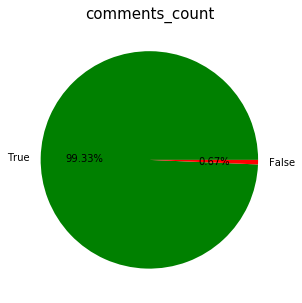

In [93]:
# Percentage of equal (True) and not equal (False).
fig, axs = plt.subplots(figsize = (5, 5))
percentage = (common["difference"] == 0).value_counts(normalize = True)
colours = {True: "green", False: "red"}
axs.pie(percentage, labels = percentage.index, colors = [colours[key] for key in percentage.index], autopct = lambda p:f"{p:.2f}%")
axs.set_title("comments_count", fontsize = 15);

In [94]:
# Isolate the usernames with difference between two sources.
difference = common[(common["difference"] != 0)]

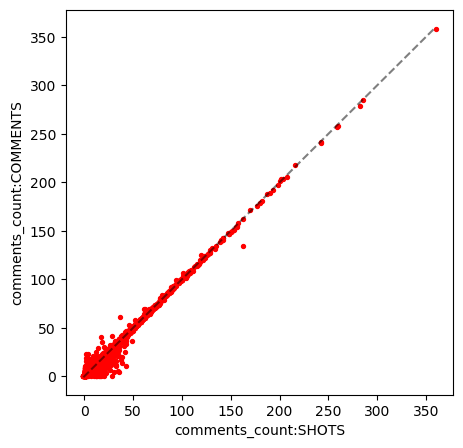

In [95]:
scatter_matplotlib(difference, x = "comments_count:SHOTS", y = "comments_count:COMMENTS")

## likes_count

In [96]:
# Count the number of unique likes received by each shot.
c.execute("""CREATE TABLE 'likes:likes_count_shots' AS SELECT shot_id, COUNT(DISTINCT like_id) 
                AS likes_count FROM likes GROUP BY shot_id""")
conn.commit()

In [97]:
likes_count_shots = pd.read_sql("SELECT * FROM 'likes:likes_count_shots'", conn)
likes_count_shots

,shot_id,likes_count
0,1,142
1,2,26
2,26,7
3,27,4
4,28,9
...,...,...
2451444,4058825,22
2451445,4058829,27
2451446,4058866,11
2451447,4058902,17


In [98]:
# Keep shots that never received a like.
shots_without_likes = shots[~shots.shot_id.isin(likes_count_shots.shot_id)]["shot_id"]

In [99]:
# Insert the values of 0 likes_count for the users that never received a like.
no_likes = pd.DataFrame(columns = likes_count_shots.columns)
no_likes["shot_id"] = shots_without_likes
no_likes["likes_count"] = 0

data_to_insert = no_likes.values.tolist()

# Insert data into sql table recursively.
c.executemany("INSERT INTO 'likes:likes_count_shots' (shot_id, likes_count) VALUES (?, ?)", data_to_insert)
conn.commit()

In [100]:
likes_count_shots = pd.read_sql("SELECT * FROM 'likes:likes_count_shots'", conn)
likes_count_shots

,shot_id,likes_count
0,1,142
1,2,26
2,26,7
3,27,4
4,28,9
...,...,...
2475306,1400008,0
2475307,1384311,0
2475308,1775037,0
2475309,459313,0


In [101]:
# Merge the two sources based on shot_id.
common = pd.merge(shots, likes_count_shots, left_on = "shot_id", right_on = "shot_id", 
                  suffixes = (":SHOTS", ":LIKES"))

# Compute the difference between the two sources.
common["difference"] = (common["likes_count:SHOTS"] - common["likes_count:LIKES"]).abs()
common

,shot_id,comments_count,likes_count:SHOTS,likes_count:LIKES,difference
0,3549658,5,51,51,0
1,3254544,7,101,101,0
2,3153930,26,192,192,0
3,3732805,4,44,44,0
4,2686725,0,27,27,0
...,...,...,...,...,...
2475306,3204628,2,25,25,0
2475307,2886712,0,20,20,0
2475308,3402864,0,10,10,0
2475309,3231855,0,30,30,0


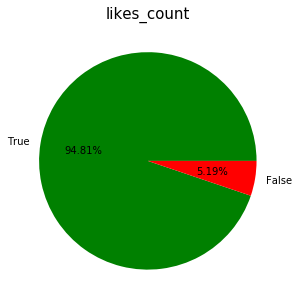

In [102]:
# Percentage of equal (True) and not equal (False).
fig, axs = plt.subplots(figsize = (5, 5))
percentage = (common["difference"] == 0).value_counts(normalize = True)
colours = {True: "green", False: "red"}
axs.pie(percentage, labels = percentage.index, colors = [colours[key] for key in percentage.index], autopct = lambda p:f"{p:.2f}%")
axs.set_title("likes_count", fontsize = 15);

In [103]:
# Isolate the usernames with difference between two sources.
difference = common[(common["difference"] != 0)]

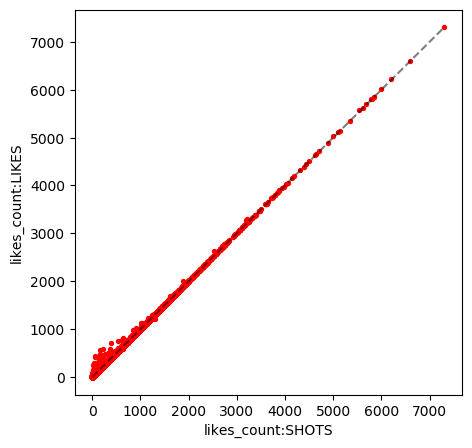

In [104]:
scatter_matplotlib(difference, x = "likes_count:SHOTS", y = "likes_count:LIKES")

In [105]:
c.execute("VACUUM");

In [106]:
conn.close()